# Koopman operator learning, a toy case: Duffing oscillator

**-- PLEASE SUBMIT YOUR COMPLETED NOTEBOOK WITH CELL OUTPUTS --**


The aim of this notebook is to describe the dynamics of a non-linear dynamical system by means of the Koopman theory.

## Introduction

We consider a quantity $x$ (a vector) which evolves with time, following a dynamical system. Think for example of the joint location of the planets in our solar system, which follows the law of gravitation.

Formally, given an initial state $x(t=0) \in \mathbb{R}^n$ at time $t=0$, the time evolution of $x$ is governed by the following dynamical system:
$$
\dot{x}(t) = f(x(t)) \quad \text(1)
$$

where $\dot{x}(t) := \frac{dx(t)}{dt}$ is the temporal derivative, and $f:\mathbb{R}^n \rightarrow \mathbb{R}^n$ is a given map describing the dynamics.

For a given $f$, it is not always possible to solve the differential equation (1) analytically. For this reason, instead, numerical schemes are usually employed, to integrate in time $t$ the equation (1), so as to propagate the initial condition $x(0)$ up to a desired time $T$; think of $x(T) = x(0) + \int_{t=0}^{T} f(x(t)) dt$. The discretization in time of eq (1) or of the integral introduces numerical approximations, and yields estimates of $x(T)$ of various quality depending on the discretization scheme.

In the field of numerical simulations, discretization schemes have been studied for a long time, and numerical solvers already exist to provide good estimates of integrals (far better than with the naive discretization $x_{k+\delta} = x_k + \delta\,f(x_k)$ for a discrete time increment $\delta$, which induces a $O(\delta^2)$ error at each time step).

The goal of this practical session is to make use of such numerical solvers to improve the learning of dynamical systems with neural networks.

In [333]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
from scipy.linalg import  eig
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.distributions as dist
import seaborn as sns
sns.set()


# arrange the dataset
from sklearn.model_selection import train_test_split

## Duffing oscillator

As a toy example, we consider the Duffing oscillator, where the state $x = (x_1, x_2) \in \mathbb{R}^2$ follows the dynamical system described by the following ODEs:

$$
\dot{x}_1 = x_2\\
\dot{x}_2 = x_1 - x_1^3
$$

To integrate in time the ODEs, a 4th order Runge-Kutta scheme can be used. 


In [3]:
def duffing(array_x: np.ndarray) -> np.ndarray:
    array_dx = np.zeros(array_x.shape)
    array_dx[0] = array_x[1]
    array_dx[1] = array_x[0] - array_x[0] ** 3
    return array_dx

In [4]:
t_max = 500  # Time-horizon integration
n_iter = 5000  # Number of time steps integration
n_initial_conditions = 60  # Number of initial conditions

dim_system = 2

# Generate initial conditions
matrix_x0 = (np.random.rand(n_initial_conditions, dim_system) - 0.5) * 4
array_t = np.linspace(0, t_max, n_iter)
array3d_xt = np.zeros((matrix_x0.shape[0], matrix_x0.shape[1], n_iter))

for i in tqdm(range(matrix_x0.shape[0])):
    # Lambda function is used as solve_ivp requires a function of the form f(t, x)
    ode_result = solve_ivp(lambda _t, array_x: duffing(array_x),
                           [0, t_max],
                           matrix_x0[i],
                           method='RK45',
                           t_eval=array_t)

    array3d_xt[i, :] = ode_result.y

100%|██████████| 60/60 [00:24<00:00,  2.41it/s]


The following plot shows trajectories for different initial conditions:

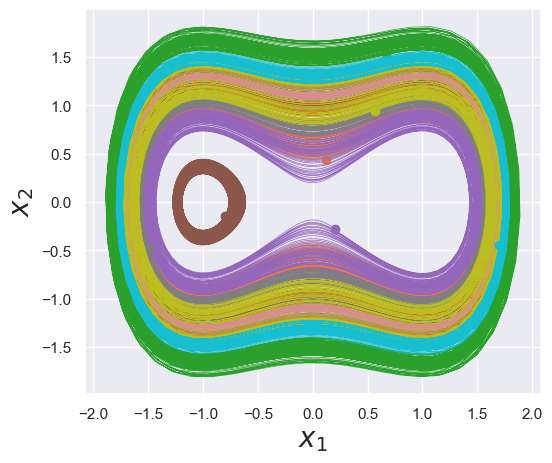

In [334]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(131)
cm = plt.get_cmap("tab10")
print(cm)
for i in range(10):
    ax.plot(array3d_xt[i, 0, :], array3d_xt[i, 1, :], lw=0.5, color=cm(i))
    ax.plot(array3d_xt[i, 0, 0], array3d_xt[i, 1, 0], 'o', lw=1.5, color=cm(i))  #initial condition
ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
plt.show()

## The Koopman operator
### Discontinuous in time case
Given the discrete non-linear dynamical system

$$
x_{k+1} = F(x_k)
$$

where $F$ might be the $\delta$-discretised flow map of the continuous dynamical system in eq (1) given by

$$
x_{k+1} = F(x_k) := x_k + \int_{k}^{k + \delta} f(x(s))ds 
$$

and $X = (x_k)_{k = 0}^N$ the discrete time series of the system state.


The _Koopman_ theory states that there exists an infinite-dimensional linear operator $\mathcal{K}$ that advances in time all observable functions $(g_i)_{i = 1}^m$ given by $g_i: \mathbb{R}^n \rightarrow \mathbb{R}$

$$
\mathcal{K} g_i(x) = g_i \circ F(x)
$$

This way, the non-linear dynamics of $x$, described by $F$, can be turned into a **linear** dynamical system, described by $\mathcal{K}$, acting on another representation space, formed by the observable quantities $g_i(x)$.

Indeed, let $g_i$ be an observable function and denoting ${g_i}_k := g_i(x_k)$, using the previous equation, the time evolution of the observables is given by

$$
{g_i}_{k+1} = g_i(x_{k+1}) = g_i(F(x_k)) = g_i \circ F(x_k) = \mathcal{K} g_i(x_k) = \mathcal{K} {g_i}_k
$$

then, the linearised dynamics of the observables is given by the following equation

$$
{g_i}_{k+1} = \mathcal{K} {g_i}_k
$$


It is then sufficient to find a function $g: \mathbb{R}^n \rightarrow \mathbb{R}^m$ with $m \gg n$ that embeds the state $x$ into a "larger enough" dimensional space $m$ such that the linear operator $\mathcal{K}$ can be inferred by a matrix $\mathbf{K} \in \mathbb{R}^{m \times m}$.

To project back the dynamics from the Koopman space ($\mathbb{R}^m$, where $g(x)$ lives) to the phase space ($\mathbb{R}^n$, where $x$ lives), a supplementary function $\varphi: \mathbb{R}^m \rightarrow \mathbb{R}^n$ is needed. Going from $x$ to the Koopman space and back yields $\varphi \text{ o  } g = $ Id.

Under this condition, the functions $g$, $\varphi$ and $\mathbf{K}$ can be parametrized $g_{\theta}$, $\varphi_{\rho}$ and $\mathbf{K}_{\phi}$, and the parameters $\theta$, $\rho$ and $\phi$ can be learned minimizing suitable loss functions. 

For this purpose, given a time series $X = \{x_k | k = 1 \ldots N \}$, the following conditions hold:


1.   Reconstruction error
     $$
     \mathcal{L}^{\text{rec}} = \Vert \varphi_\rho (g_\theta(x_k)) - x_k  \Vert = 0
     $$
2.   Prediction error in Koopman space
     $$
     \mathcal{L}^{\text{pred koop}} = \Vert \mathbf{K_{\phi}} g_{\theta} ( x_k ) - g_{\theta} (x_{k+1})  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \mathcal{L}^{\text{pred phase}} =\Vert \varphi_{\rho} \left( \mathbf{K_{\phi}} g_{\theta} ( x_k )\right) - x_{k+1} \Vert = 0
     $$

The last three errors can be used as loss functions to train three different neural networks. These different neural networks compose our architecture that can be summarized as in the following sketch:



![architecture](./architecture.png) 

You can see below the dimension of data, the data matrix has shape: <code>size_batch $\times$ n </code>

In [6]:

# Flatten the trajectories w.r.t. initial conditions 
# and only keep data in the form of (dim_system, n_iter * n_initial_conditions)
matrix_x_data = array3d_xt[:, :, :-1].swapaxes(0, 1).reshape(2, -1).T
matrix_x_next_data = array3d_xt[:, :, 1:].swapaxes(0, 1).reshape(2, -1).T

(matrix_x_data_train,
 matrix_x_data_test,
 matrix_x_next_data_train,
 matrix_x_next_data_test) = train_test_split(matrix_x_data,
                                             matrix_x_next_data,
                                             test_size=0.2)

# Cast type to float32
matrix_x_data_train = matrix_x_data_train.astype(np.float32)
matrix_x_data_test = matrix_x_data_test.astype(np.float32)
matrix_x_next_data_train = matrix_x_next_data_train.astype(np.float32)
matrix_x_next_data_test = matrix_x_next_data_test.astype(np.float32)

print(matrix_x_data_train.shape,
      matrix_x_data_test.shape,
      matrix_x_next_data_train.shape,
      matrix_x_next_data_test.shape)

(239952, 2) (59988, 2) (239952, 2) (59988, 2)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type('torch.DoubleTensor')

batch_size = 2000  # data per batch

tensor2d_x_data_train = torch.from_numpy(matrix_x_data_train).to(device)
tensor2d_x_next_data_train = torch.from_numpy(matrix_x_next_data_train).to(device)
tensor2d_x_data_test = torch.from_numpy(matrix_x_data_test).to(device)
tensor2d_x_next_data_test = torch.from_numpy(matrix_x_next_data_test).to(device)

torch_dataset_train = TensorDataset(tensor2d_x_data_train,
                                    tensor2d_x_next_data_train)

torch_dataset_test = TensorDataset(tensor2d_x_data_test,
                                   tensor2d_x_next_data_test)

train_dataloader = DataLoader(torch_dataset_train,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(torch_dataset_test,
                             batch_size=batch_size,
                             shuffle=True)

# create the models
feature_dim = 2  # dimension of the Duffing oscillator
hidden_layer = 5  # number of hidden layers in g (ENCODER) and \varphi (DECODER) 
output_dim = 30  # dimension in Koopman space

In [9]:
class Encoder(nn.Module):
    def __init__(self, list_layer_dim: list):
        super().__init__()
        self.list_layer_dim = list_layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.list_layer_dim) - 1):
            input_dim = self.list_layer_dim[i]
            output_dim = self.list_layer_dim[i + 1]
            self.list_FC.append(nn.Linear(input_dim, output_dim))

    def forward(self, tensor2d_x):
        for i in range(len(self.list_layer_dim) - 2):
            tensor2d_x = F.elu(self.list_FC[i](tensor2d_x))
        return self.list_FC[-1](tensor2d_x)

In [10]:
class Decoder(nn.Module):
    def __init__(self, list_layer_dim: list):
        super().__init__()
        self.list_layer_dim = list_layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.list_layer_dim) - 1, 0, -1):
            input_dim = self.list_layer_dim[i]
            output_dim = self.list_layer_dim[i - 1]
            self.list_FC.append(nn.Linear(input_dim, output_dim))

    def forward(self, tensor2d_x: torch.Tensor):
        for i in range(len(self.list_layer_dim) - 2):
            tensor2d_x = F.elu(self.list_FC[i](tensor2d_x))
        return self.list_FC[-1](tensor2d_x)

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, feature_dim: int, hidden_layer: int, output_dim: int):
        super().__init__()
        list_layer_dim = \
            [output_dim if i == hidden_layer
             else feature_dim + i * (output_dim - feature_dim) // hidden_layer
             for i in range(hidden_layer + 1)]
        self.encoder = Encoder(list_layer_dim)
        self.decoder = Decoder(list_layer_dim)

    def forward(self, tensor2d_x: torch.Tensor):
        tensor2d_x = self.Encoder(tensor2d_x)
        return self.Decoder(tensor2d_x)

The Koopman operator $\mathbf{K}$ (which is linear, and thus a matrix) must have a [spectral radius](https://en.wikipedia.org/wiki/Spectral_radius) $\rho(\mathbf{K})\le 1$. Such condition will provide a stable -or at least a marginally stable- Koopman operator. To fulfill this requirement, we might leverage on the Perron-Frobenius theorem. 

The Perron-Frobenius th. states: if $\mathbf{K}$ is a $m \times m$ positive matrix i.e. $k_{ij} > 0$ for $1 \le i,j \le m$, then the following inequality holds:

$$
\min_i \sum_j k_{ij} \le \rho(\mathbf{K}) \le \max_i \sum_j k_{ij}
$$


**Question 1.** : Complete the `KoopmanModule` class to enforce $\rho(\mathbf{K})\le 1$, using the Perron-Frobenius theorem. Check that the initialization fulfills this property.

In [67]:
class KoopmanOperator(nn.Module):
    def __init__(self, koopman_operator_dim: int):
        super().__init__()
        self.koopman_operator_dim = koopman_operator_dim
        self.koopman_operator = torch.nn.Linear(koopman_operator_dim, koopman_operator_dim, bias = False)
        torch.nn.init.uniform_(self.koopman_operator.weight, b = 100)
        self.initialize()

    def initialize(self):
        sum_row = torch.sum(self.koopman_operator.weight, axis=1)
        max_row = torch.max(sum_row)
        with torch.no_grad():
            self.koopman_operator.weight /= max_row

    def forward(self, tensor2d_x: torch.Tensor):
        # First dimension of tensor2d_x is the batch size
        if tensor2d_x.shape[1] != self.koopman_operator_dim:
            sys.exit(f'Wrong Input Features. Please use tensor'
                     f' with {self.koopman_operator_dim} Input Features')
        return self.koopman_operator(tensor2d_x)

dim_observable = 10
koopman_operator = KoopmanOperator(dim_observable)

In [68]:
import sys
for _ in range(1000):
    K = KoopmanOperator(10)
    with torch.no_grad(): #Deactivate the computational graph
        eigv, _ = eig(K.koopman_operator.weight)

    rad_spec = np.max(np.abs(eigv))
    if rad_spec > 1:
        sys.exit("Spectral radius is above 1.")

In [69]:
autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
koopman_operator = KoopmanOperator(output_dim).to(device)
print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=2, out_features=7, bias=True)
      (1): Linear(in_features=7, out_features=13, bias=True)
      (2): Linear(in_features=13, out_features=18, bias=True)
      (3): Linear(in_features=18, out_features=24, bias=True)
      (4): Linear(in_features=24, out_features=30, bias=True)
    )
  )
  (decoder): Decoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=30, out_features=24, bias=True)
      (1): Linear(in_features=24, out_features=18, bias=True)
      (2): Linear(in_features=18, out_features=13, bias=True)
      (3): Linear(in_features=13, out_features=7, bias=True)
      (4): Linear(in_features=7, out_features=2, bias=True)
    )
  )
)


In [70]:
learning_rate_autoencoder = 0.0001
learning_rate_koopman = 0.00001

optimiser_autoencoder = torch.optim.Adam(autoencoder.parameters(),
                                         lr=learning_rate_autoencoder)

optimiser_koopman = torch.optim.Adam(koopman_operator.parameters(),
                                     lr=learning_rate_koopman)

**Question 2.** : Define a function to compute the loss to be minimized. It should at least include the 3 terms listed above:
- Reconstruction error
- Prediction error in the Koopman space
- Prediction error in the phase space

Because the different objectives outlined by these losses may compete, the training can be difficult. You may try different variations on these losses and comment your findings. In order to improve the training process, one can for instance:
- Add a multiplicative factor in front of each loss component, to balance their importance; how the scales of different losses are related?
- We can refine the loss acting upon the latent space, by using a variational autoencoder approach. This is similar to the Gaussian likelihood used in the first practical (TD1). We want the prediction in the latent space (i.e. the Koopman space) to be a normal distribution $\mathcal{N}(0, 1)$ . Add a corresponding loss for the latent space. Difference to 0 mean and 1 standard deviation must be thus included in the loss. In my case, I'll penalise the loss via a $L^2$ MSE. It boils down to add $||\text{mean}(gX\_)||^2 + ||\sigma(gX\_) - 1||^2$;
- Freeze the gradients of one part of the network, for instance the encoder, for one specific objective, using the [`requires_grad`](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) property. For instance:
```python
criterion = nn.MSELoss()
...
# Compute one part loss_l of the total loss
# First deactivate gradient computation for irrelevant parts of the architecture
for p in autoencoder.encoder.parameters():
    p.requires_grad = False
loss_l = criterion(pred, target)
# Restore the gradient computation
for p in autoencoder.encoder.parameters():
    p.requires_grad = True
...
total_loss = loss_1 + ... + loss_l + ...
```

We noted $X\_: x_k, \quad$ $Y\_: x_{k+1}, \quad$ $X_{\text{recon}} = \varphi_\rho(g_\theta(x_k)), \quad$ $\text{gY}\_ : K_{\phi} g_{\theta} ( x_k ), \quad$ $gY_{\text{pred}}: g_\theta(x_{k+1}), \quad$ $Y_{\text{pred}}: \varphi_{\rho} \left( \mathbf{K_{\phi}} g_{\theta} ( x_k )\right)$

In [224]:
# HINT: See the training process below to identify the different components of the loss
def loss_koopman(tensor2d_x: torch.Tensor,
                 tensor2d_x_next: torch.Tensor,
                 tensor2d_decoded_x: torch.Tensor,
                 tensor2d_observable: torch.Tensor,
                 tensor2d_observable_next: torch.Tensor,
                 tensor2d_koopman_observable_next: torch.Tensor,
                 tensor2d_predict_x_next: torch.Tensor,
                 alpha: float,
                 beta: float,
                 gamma: float):

    criterion = torch.nn.MSELoss()
    #first Loss
    #Reconstruction loss does not use the Koopman operator
    for param in autoencoder.encoder.parameters():
        param.requires_grad=False
    loss1 = criterion(tensor2d_decoded_x, tensor2d_x)*alpha
    for param in autoencoder.encoder.parameters():
        param.requires_grad=True

    #Second Loss
    for param in autoencoder.decoder.parameters():
        param.requires_grad=False
    loss2 = criterion(tensor2d_koopman_observable_next, tensor2d_observable_next)*beta
    for param in autoencoder.decoder.parameters():
        param.requires_grad=True

    #Third loss
    for param in koopman_operator.parameters():
        param.requires_grad = False
    loss3 = criterion(tensor2d_x_next, tensor2d_predict_x_next)*gamma
    for param in koopman_operator.parameters():
        param.requires_grad = True
    
    loss4 = torch.mean(tensor2d_observable)**2 + (torch.std(tensor2d_observable) - 1)**2

    total_loss = loss1 + loss2 + loss3 + loss4
    return total_loss


1.   Reconstruction error
$$
\Vert \varphi_\rho (g_\theta(x_k)) - x_k  \Vert = 0
$$
2.   Prediction error in Koopman space
$$
\Vert \mathbf{K_{\phi}} g_{\theta} ( x_k ) - g_{\theta} (x_{k+1})  \Vert = 0
$$
3.   Prediction error in the phase space
$$
\Vert \varphi_{\rho} \left( \mathbf{K_{\phi}} g_{\theta} ( x_k )\right) - x_{k+1} \Vert = 0
$$


**Question 3.**: The following cell executes the training loop. You can modify it in order to display the different intermediate losses computed in the function `LOSS` above. How do they evolve in time? Justify your final choice.

The parameter $\alpha, \beta$ and $\gamma$ will take values in the range $[.1, 10]$. Each coefficients will take three differents values, making a total of $3^3=27$ combinations to test.

0 116.64224272966385
-------------------------------------------------- TEST --------------------------------------------------
0 0.9720235466957092
----------------------------------------------------------------------------------------------------------
1 116.63543671369553
2 116.62826013565063
3 116.62131094932556
4 116.6140593290329
5 116.6068212389946
6 116.59934389591217
7 116.5919161438942
8 116.58456951379776
9 116.5770913362503
0 116.57159388065338
-------------------------------------------------- TEST --------------------------------------------------
0 0.9714193940162659
----------------------------------------------------------------------------------------------------------
1 116.56407976150513
2 116.55693107843399
3 116.54971224069595
4 116.54290455579758
5 116.53586339950562
6 116.52918016910553
7 116.52271991968155
8 116.51633554697037
9 116.51035445928574
0 116.50636649131775
-------------------------------------------------- TEST -------------------------------------

Text(0.5, 0.98, 'Train Loss')

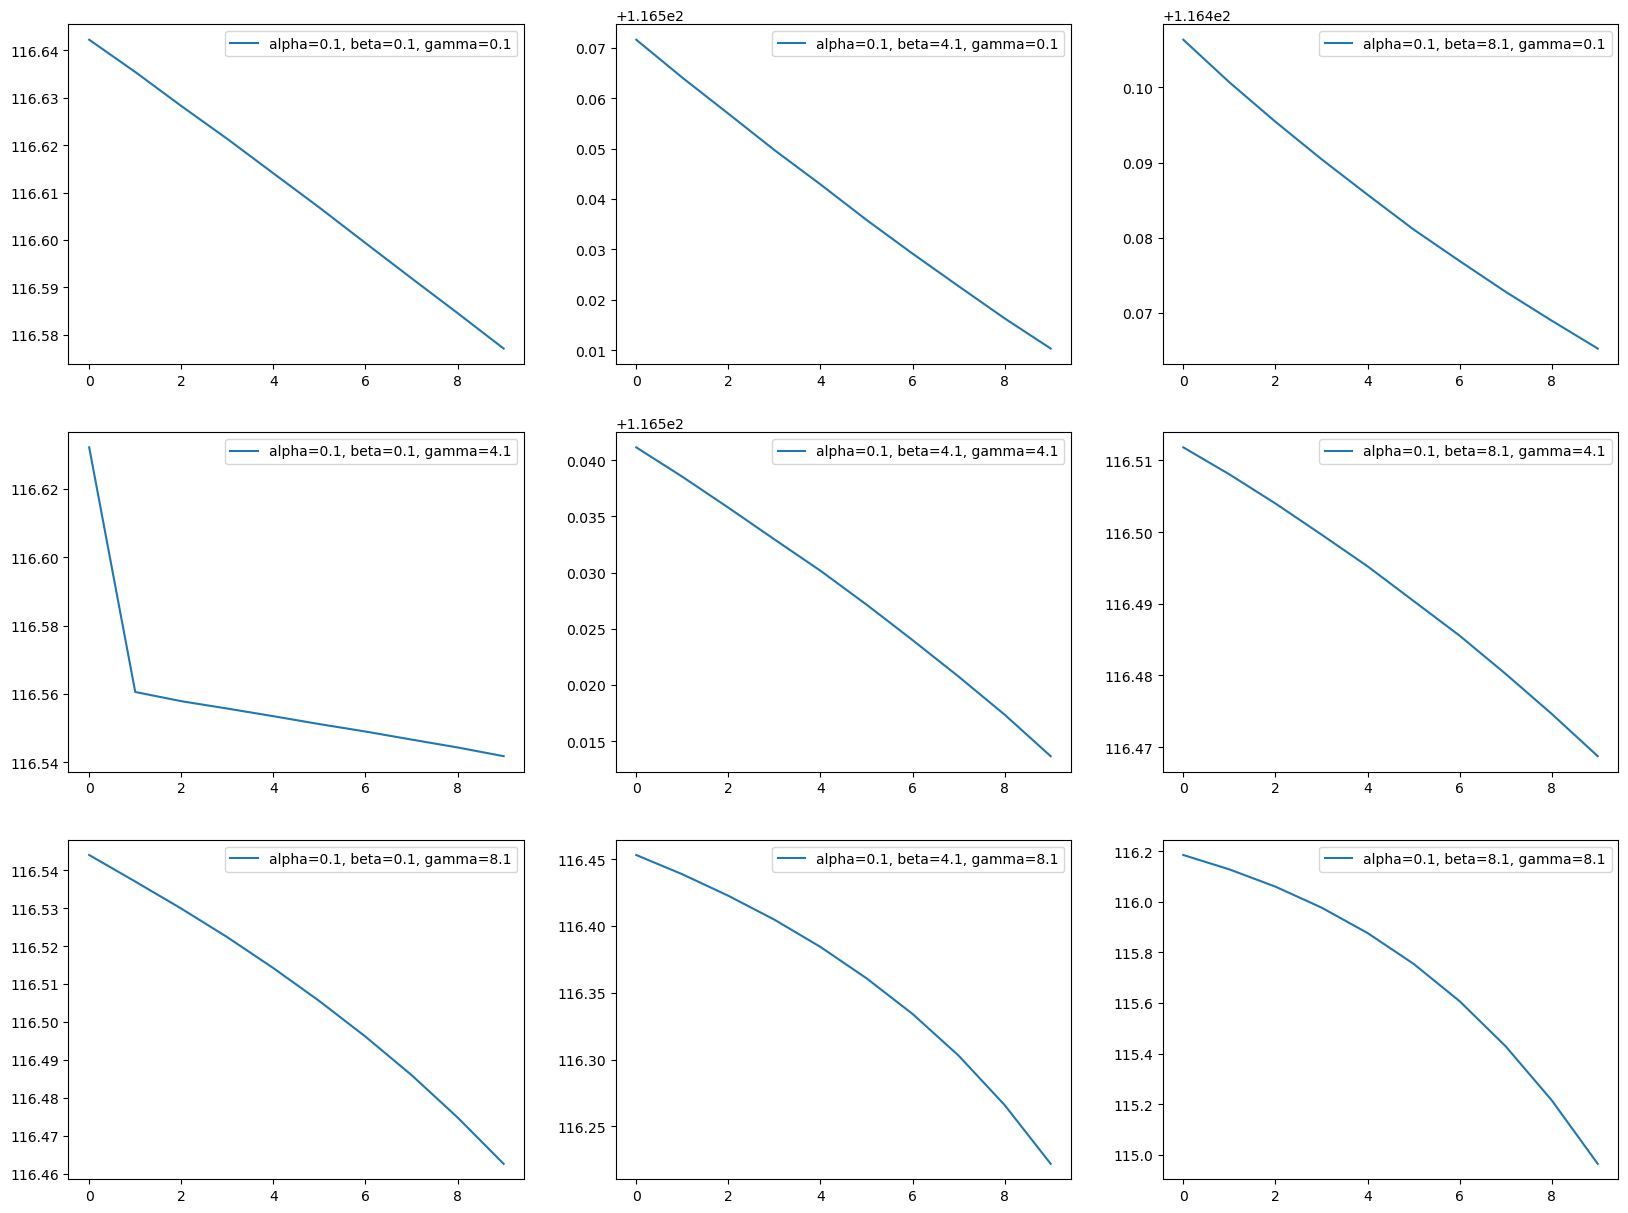

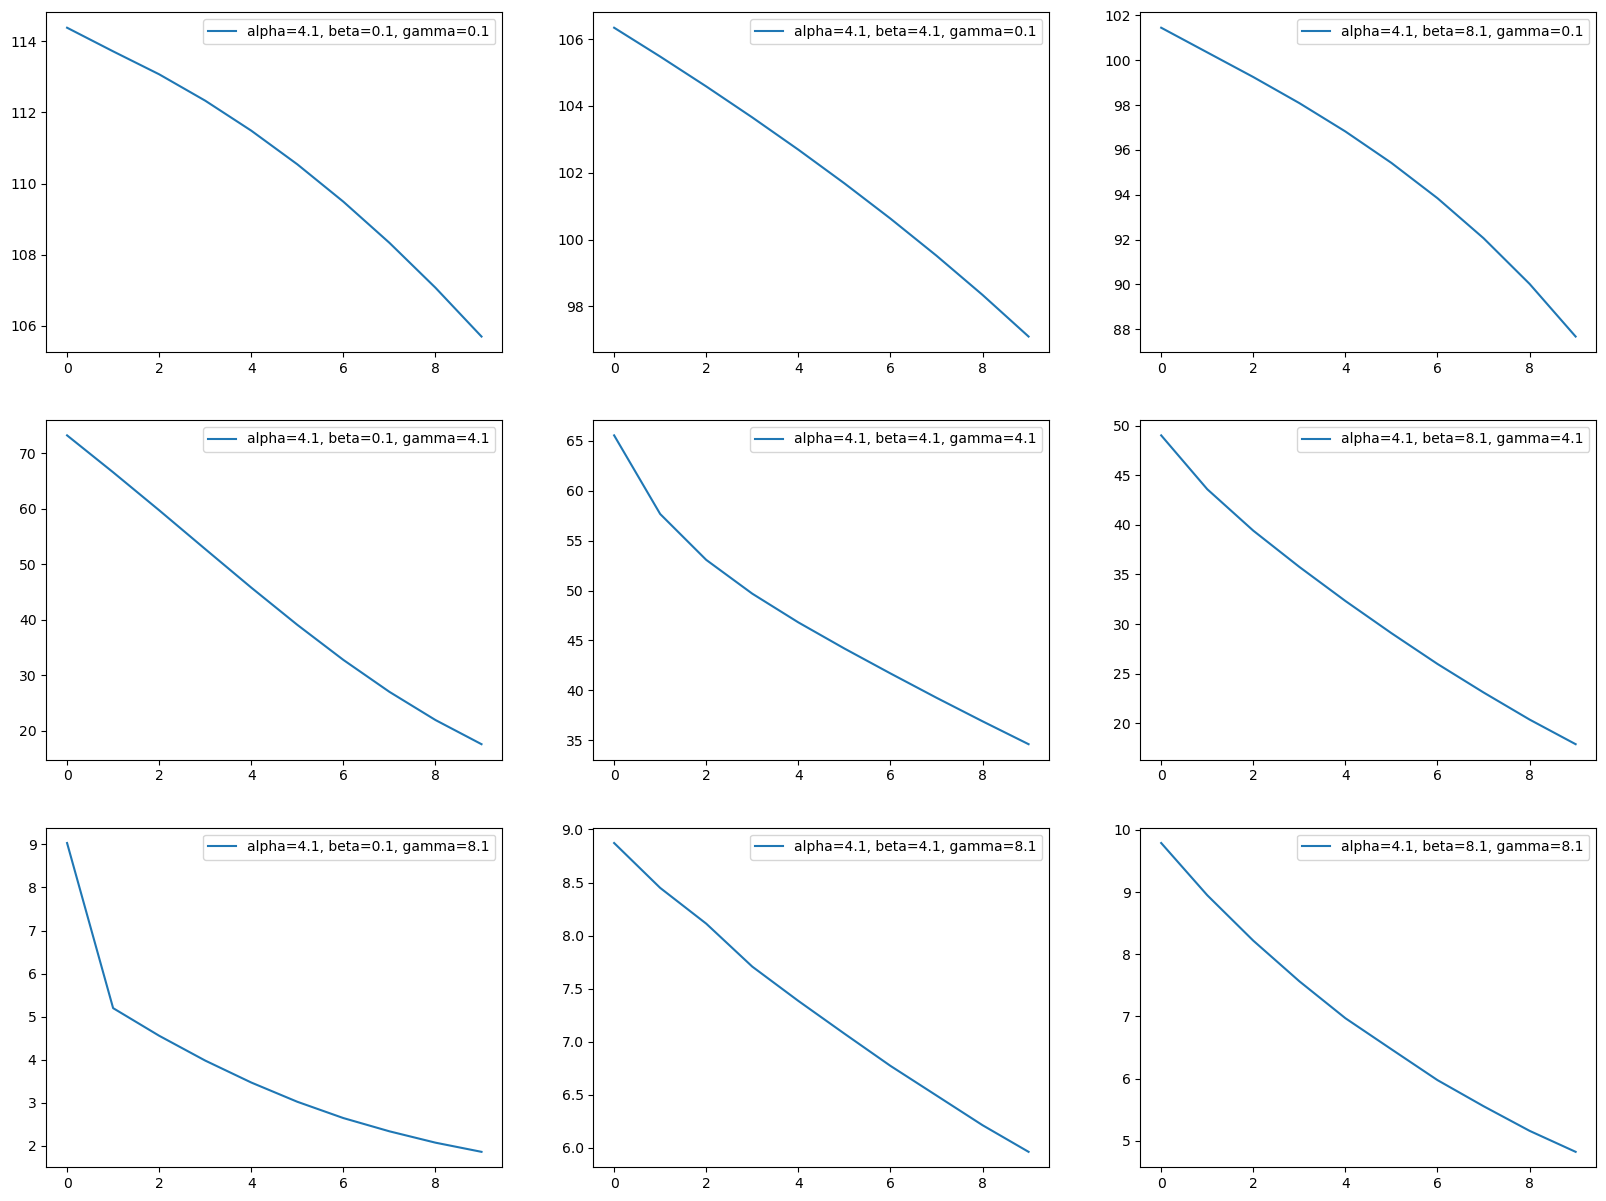

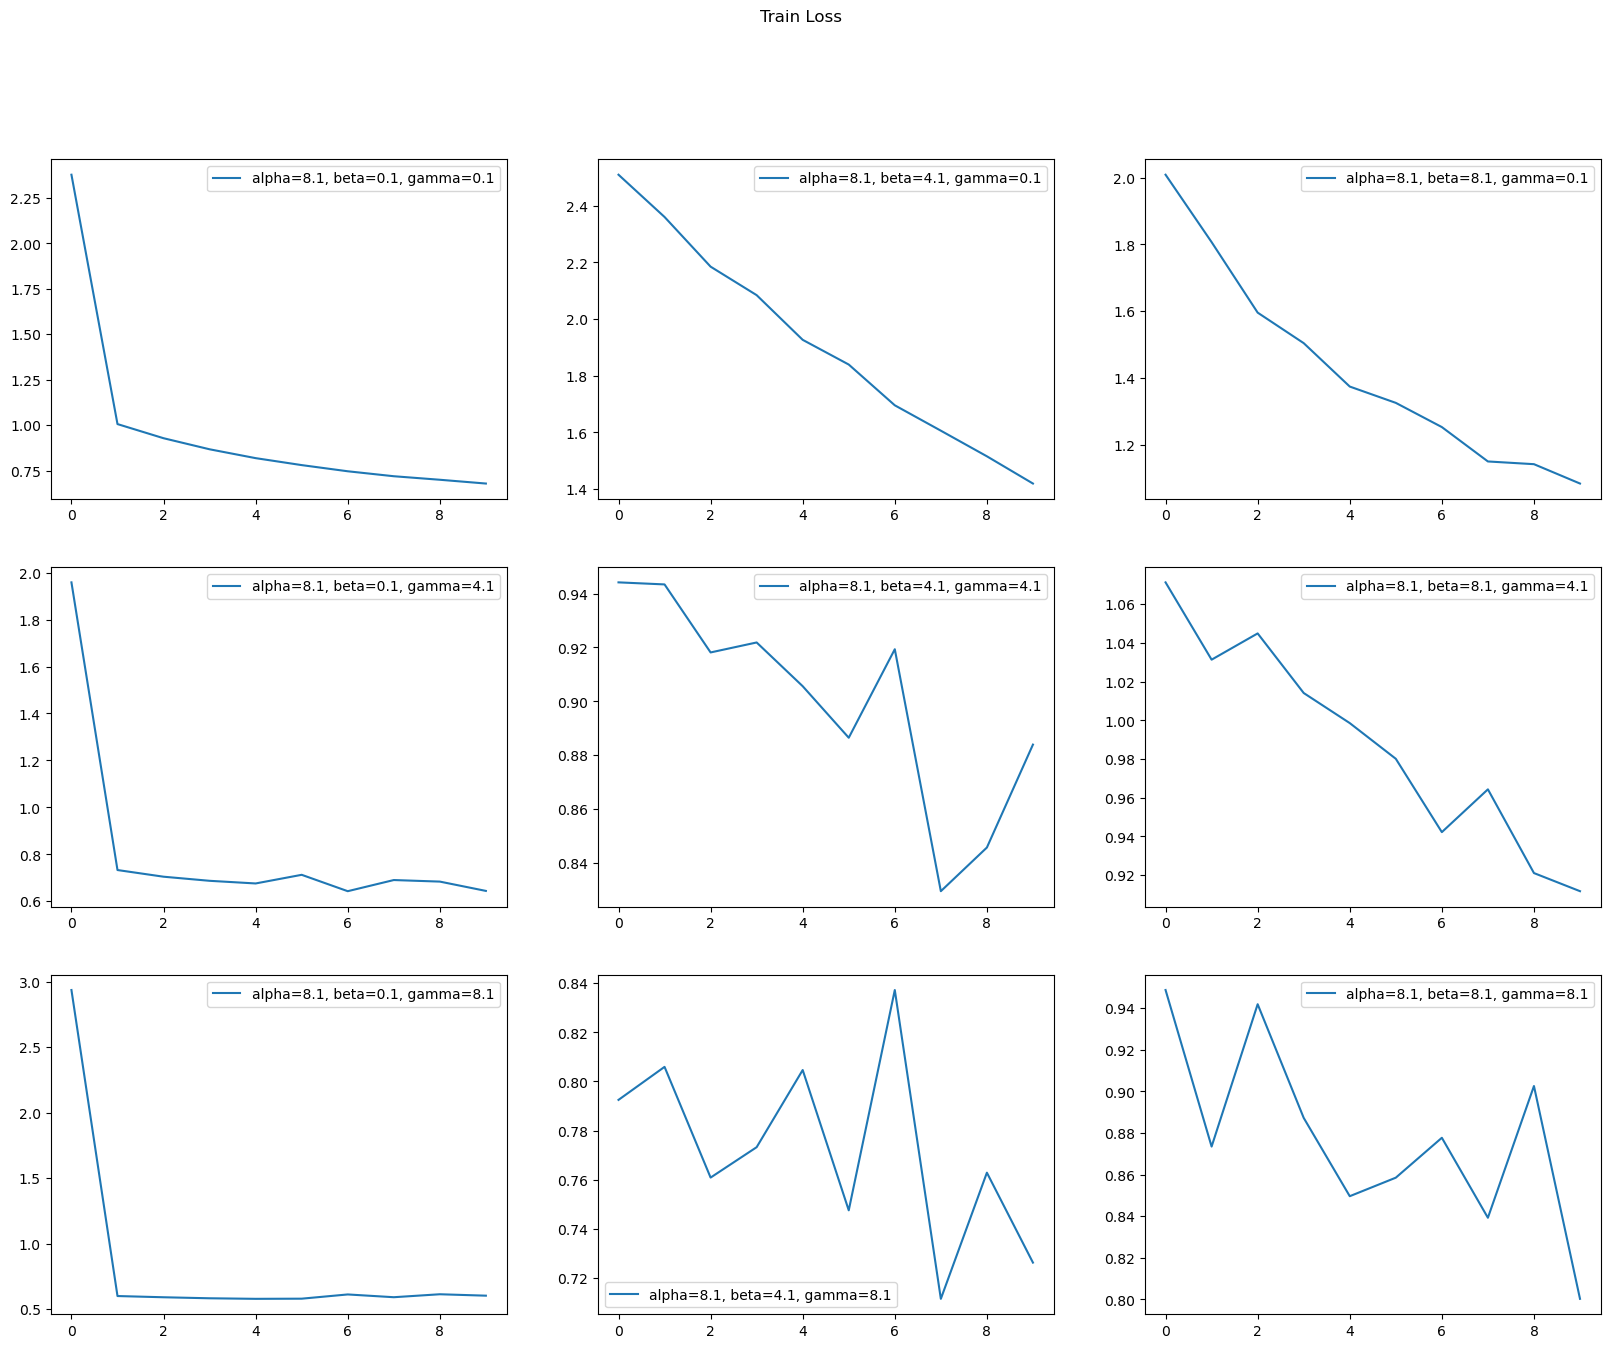

In [117]:
n_batch = len(train_dataloader)
n_epoch = 10  # To be tuned 
plot_train_loss = []

range_ = np.arange(.1,10,4)

beta_, gamma_ = np.meshgrid(range_, range_)
beta, gamma = beta_.reshape(9,1), gamma_.reshape(9,1)

weights = np.concatenate((beta, gamma), axis = -1)

for i, (alpha) in enumerate(range_):
    fig, ax = plt.subplots(3, 3, figsize=(20,15))
    for i, (beta, gamma) in enumerate(weights):
        plot_train_loss = []
        for epoch in range(n_epoch):
            autoencoder.train()
            koopman_operator.train()
            total_train_loss = 0
            total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
            for tensor2d_batch_x, tensor2d_batch_x_next in train_dataloader:
                tensor2d_batch_x = tensor2d_batch_x.to(device)
                tensor2d_batch_x_next = tensor2d_batch_x_next.to(device)

                optimiser_autoencoder.zero_grad()
                optimiser_koopman.zero_grad()

                tensor2d_observable = autoencoder.encoder(tensor2d_batch_x)
                tensor2d_observable_next = autoencoder.encoder(tensor2d_batch_x_next)

                tensor2d_decoded_x = autoencoder.decoder(tensor2d_observable)

                tensor2d_koopman_observable_next = koopman_operator(tensor2d_observable)

                tensor2d_predict_x_next = autoencoder.decoder(tensor2d_koopman_observable_next)

                tensor_loss_val = loss_koopman(tensor2d_batch_x,
                                            tensor2d_batch_x_next,
                                            tensor2d_decoded_x,
                                            tensor2d_observable,
                                            tensor2d_observable_next,
                                            tensor2d_koopman_observable_next,
                                            tensor2d_predict_x_next, alpha, beta, gamma)

                tensor_loss_val.backward()
                optimiser_autoencoder.step()
                optimiser_koopman.step()

                if epoch % 1 == 0:
                    total_train_loss += tensor_loss_val.item()

            if epoch % 1 == 0:
                plot_train_loss += [total_train_loss]
                print(epoch, total_train_loss)

            if epoch % 10 == 0:
                autoencoder.eval()
                koopman_operator.eval()
                tensor_loss_val = None
                with torch.no_grad():
                    total_test_loss = 0
                    for tensor2d_batch_x, tensor2d_batch_x_next in test_dataloader:
                        tensor2d_batch_x = tensor2d_batch_x.to(device)
                        tensor2d_batch_x_next = tensor2d_batch_x_next.to(device)

                        tensor2d_observable = \
                            autoencoder.encoder(tensor2d_batch_x)
                        tensor2d_observable_next = \
                            autoencoder.encoder(tensor2d_batch_x_next)
                        tensor2d_decoded_x = \
                            autoencoder.decoder(tensor2d_observable)
                        tensor2d_koopman_observable_next = \
                            koopman_operator(tensor2d_observable)
                        tensor2d_predict_x_next = \
                            autoencoder.decoder(tensor2d_koopman_observable_next)

                        tensor_loss_val = loss_koopman(tensor2d_batch_x,
                                                    tensor2d_batch_x_next,
                                                    tensor2d_decoded_x,
                                                    tensor2d_observable,
                                                    tensor2d_observable_next,
                                                    tensor2d_koopman_observable_next,
                                                    tensor2d_predict_x_next,
                                                    alpha, 
                                                    beta, 
                                                    gamma)

                    total_test_loss += tensor_loss_val.item()
                    print('-' * 50, 'TEST', '-' * 50)
                    print(epoch, total_test_loss)
                    print('-' * 106)

        ax[i//3][i%3].plot(plot_train_loss, label=f"alpha={alpha}, beta={beta}, gamma={gamma}")
        ax[i//3][i%3].legend()

        fig.suptitle("Train Loss")

First, We observe immediately that the larger $\alpha$ is, the smaller the loss, and by a large factor. Multiplying $\alpha$ by $100$ divides the total loss by the same amount, which is actually quite counterintuitive.
Similar effect is observed for $\gamma$ and $\beta$, but not at the same order of magnitude. The factor $\alpha$ is clearly the coefficient with the most influence.

#### Verification

**Question 4.** : We want to ensure the Koopman operator is stable. This can be verified by checking whether its spectral radius $\rho(\mathbf{K})\le 1$. Plot the eigenvalues of the Koopman operator in order to verify the bound on its spectral radius. You can use the [`numpy.linalg.eig`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) function to retrieve the eigenvalues of a matrix.

(-1.0994713455438614,
 1.0999748259782791,
 -1.0998615264892577,
 1.0998615264892577)

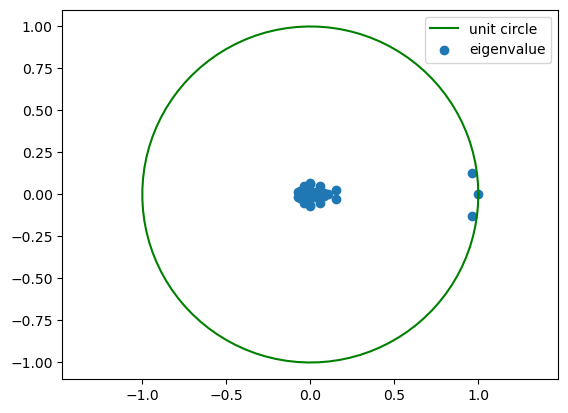

In [135]:
with torch.no_grad():
    eigv, _ = eig(koopman_operator.koopman_operator.weight.cpu())

theta = torch.linspace(0, 2*np.pi, 100)
plt.plot(torch.cos(theta), torch.sin(theta), color = 'g', label = 'unit circle')
plt.scatter(eigv.real, eigv.imag, label='eigenvalue')
plt.legend()
plt.axis('equal')

In [134]:
n_grid = 30
x1_min, x1_max = -2, 2
x2_min, x2_max = -2, 2

array_x1 = np.linspace(x1_min, x1_max, n_grid, dtype=np.float32)
array_x2 = np.linspace(x2_min, x2_max, n_grid, dtype=np.float32)
matrix_grid_x1, matrix_grid_x2 = np.meshgrid(array_x1, array_x2)

array3d_dynamics = np.zeros((n_grid, n_grid, 2), dtype=np.float32)

for i in range(n_grid):
    for j in range(n_grid):
        x1 = matrix_grid_x1[i, j]
        x2 = matrix_grid_x2[i, j]
        array3d_dynamics[i, j, :] = duffing(np.array([x1, x2]))

# Set evaluation mode
autoencoder.eval()
koopman_operator.eval()

array3d_dynamics_pred = np.zeros((n_grid, n_grid, 2), dtype=np.float32)

for i in range(n_grid):
    for j in range(n_grid):
        x1 = matrix_grid_x1[i, j]
        x2 = matrix_grid_x2[i, j]
        tensor2d_x = torch.tensor([[x1, x2]], dtype=torch.float32).to(device)
        tensor2d_observable = autoencoder.encoder(tensor2d_x)
        tensor2d_koopman_observable_next = koopman_operator(tensor2d_observable)
        tensor2d_predict_x_next = autoencoder.decoder(tensor2d_koopman_observable_next)
        array_x_next = tensor2d_predict_x_next.cpu().detach().numpy().ravel()

        # Here we compute a discretised version of the derivative thanks to the Koopman operator
        # and the learned encoder/decoder

        # (x_{k+1} - x_k) / \delta_t = f(x_k) is approximated by (f is duffing here)
        # (Decod(K(Encod(x_k))) - x_k) / \delta_t

        delta_time = (t_max / n_iter)
        array3d_dynamics_pred[i, j, :] = (array_x_next - [x1, x2]) / delta_time


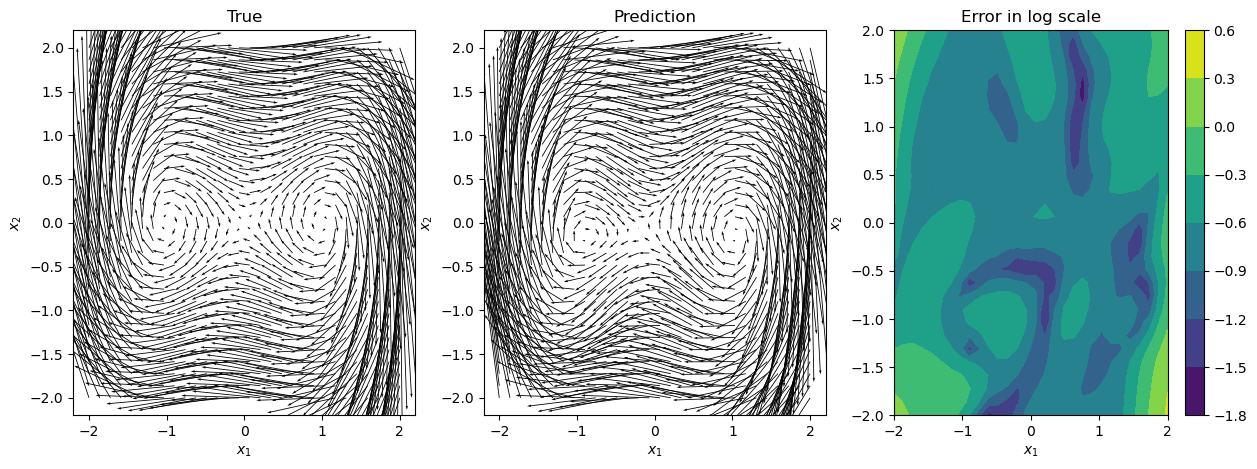

In [136]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.quiver(matrix_grid_x1,
          matrix_grid_x2,
          array3d_dynamics[:, :, 0],
          array3d_dynamics[:, :, 1], scale=10)
ax.set_title('True')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(132)
ax.quiver(matrix_grid_x1,
          matrix_grid_x2,
          array3d_dynamics_pred[:, :, 0],
          array3d_dynamics_pred[:, :, 1], scale=10)

ax.set_title('Prediction')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

# Compute the error
matrix_error = np.linalg.norm(array3d_dynamics - array3d_dynamics_pred, axis=2)
matrix_error_log = np.log10(matrix_error + 1e-10)

ax = fig.add_subplot(133)
cp = ax.contourf(matrix_grid_x1,
                 matrix_grid_x2,
                 matrix_error_log)

fig.colorbar(cp)
ax.set_title('Error in log scale')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

### Continuous in time case

Considering $x_k$ as the observation of a state at time $t = k \delta$, and $x_{k+1}$ the state at time $t+ \delta$, for $\delta \rightarrow 0$  it is also possible to define the continuous-time infinitesimal generator of the Koopman operator family as

$$
\mathcal{L} g (x_k)  = \lim_{\delta \rightarrow 0} \frac{\mathcal{K}g(x_k)- g(x_{k})}{\delta} = \frac{g \circ F (x_k) -x_k}{\delta}
$$

The pevious expression defines the Lie derivative, and for this reason $\mathcal{L}$ is known as the Lie operator. $\mathcal{L}$ describes the continuous dynamics of the observables in the Koopman space:

$$
\dot{g} (x) = \mathcal{L} g(x).
$$

The latter can be further expressed as:

$$
\dot{g} (x(t)) = \frac{dg(x)}{dt} = \nabla_x g \frac{dx}{dt} = \nabla_x g \cdot f(x) =\mathcal{L} g(x).
$$

Given $g_{\theta}$, $\varphi_{\rho}$ and $\mathbf{L}_{\phi}$ three parameterized functions, the following conditions hold:

1.   Reconstruction error
     $$
     \Vert \varphi_\rho (g_\theta(x)) - x  \Vert = 0
     $$
2.   Prediction error in Koopman space
     $$
     \Vert \mathbf{L_{\phi}} g_{\theta} ( x ) - \nabla g_{\theta} \cdot f(x)  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \Vert \varphi_{\rho} \left( \mathbf{L_{\phi}} g_{\theta} ( x )\right) - f(x) \Vert = 0
     $$

**Important Remark: As long as the system $f$ is known, the three errors can be computed without data belonging to trajectories.**

In [137]:
# Create a dataset for continuous Koopman
# with the same amount of points of the Discontinuous Koopman case
# But here no need to have continuous trajectories
matrix_x0 = (np.random.rand(n_initial_conditions * (n_iter - 1), 2) - 0.5) * 4
matrix_system_derivative_data = np.zeros(matrix_x0.shape)
for i in tqdm(range(matrix_x0.shape[0])):
    matrix_system_derivative_data[i, :] = duffing(matrix_x0[i, :])

100%|██████████| 299940/299940 [00:00<00:00, 472929.06it/s]


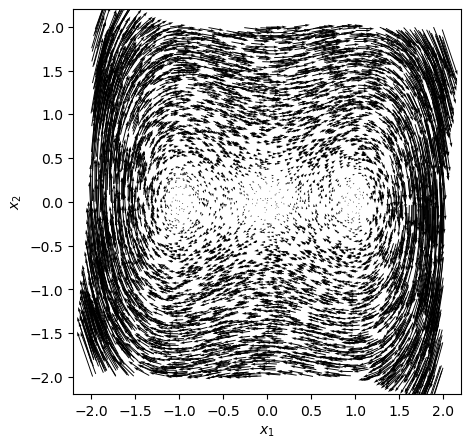

In [138]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.quiver(matrix_x0[::50, 0],
          matrix_x0[::50, 1],
          matrix_system_derivative_data[::50, 0] * 0.2,
          matrix_system_derivative_data[::50, 1] * 0.2, scale=10)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

In [139]:
# create the models
feature_dim = 2  # dimension of the Duffing oscillator
hidden_layer = 5  # number of hidden layers in g (ENCODER) and \varphi (DECODER) 
output_dim = 30  # dimension in Koopman space
batch_size = 2000  # data per batch

In [216]:
(matrix_x_data_train,
 matrix_x_data_test,
 matrix_x_next_data_train,
 matrix_x_next_data_test) = train_test_split(matrix_x0,
                                             matrix_system_derivative_data,
                                             test_size=0.2)

# Cast type to float32
matrix_x_data_train = matrix_x_data_train.astype(np.float32)
matrix_x_data_test = matrix_x_data_test.astype(np.float32)
matrix_x_next_data_train = matrix_x_next_data_train.astype(np.float32)
matrix_x_next_data_test = matrix_x_next_data_test.astype(np.float32)

print(matrix_x_data_train.shape,
      matrix_x_data_test.shape,
      matrix_x_next_data_train.shape,
      matrix_x_next_data_test.shape)

torch_dataset_train = TensorDataset(torch.from_numpy(matrix_x_data_train),
                                    torch.from_numpy(matrix_x_next_data_train))
torch_dataset_test = TensorDataset(torch.from_numpy(matrix_x_data_test),
                                   torch.from_numpy(matrix_x_next_data_test))

train_dataloader = DataLoader(torch_dataset_train,
                              batch_size=batch_size,
                              shuffle=True)

test_dataloader = DataLoader(torch_dataset_test,
                             batch_size=batch_size,
                             shuffle=True)

(239952, 2) (59988, 2) (239952, 2) (59988, 2)


In [217]:
class Encoder(nn.Module):
    def __init__(self, list_layer_dim):
        super().__init__()
        self.list_layer_dim = list_layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.list_layer_dim) - 1):
            dim_input = self.list_layer_dim[i]
            dim_output = self.list_layer_dim[i + 1]
            self.list_FC.append(nn.Linear(dim_input, dim_output))

    def forward(self, tensor2d_x):
        for i in range(len(self.list_layer_dim) - 2):
            tensor2d_x = F.elu(self.list_FC[i](tensor2d_x))
        return self.list_FC[-1](tensor2d_x)

In [218]:
class Decoder(nn.Module):
    def __init__(self, list_layer_dim):
        super().__init__()
        self.list_layer_dim = list_layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.list_layer_dim) - 1, 0, -1):
            dim_input = self.list_layer_dim[i]
            dim_output = self.list_layer_dim[i - 1]
            self.list_FC.append(nn.Linear(dim_input, dim_output))

    def forward(self, tensor2d_x):
        for i in range(len(self.list_layer_dim) - 2):
            tensor2d_x = F.elu(self.list_FC[i](tensor2d_x))
        return self.list_FC[-1](tensor2d_x)

In [219]:
class Autoencoder(nn.Module):
    def __init__(self, feature_dim, hidden_layer, output_dim):
        super().__init__()

        list_layer_dim = \
            [output_dim if i == hidden_layer
             else feature_dim + i * (output_dim - feature_dim) // hidden_layer
             for i in range(hidden_layer + 1)]

        self.encoder = Encoder(list_layer_dim)
        self.decoder = Decoder(list_layer_dim)

    def forward(self, tensor2d_x: torch.Tensor):
        tensor2d_x = self.encoder(tensor2d_x)
        return self.decoder(tensor2d_x)

The Lie operator must be defined such that it will be always stable by construction.
To do that, we consider a matrix of parameters $\Psi \in \mathbb{R}^{m \times m}$ and a vector of parameters $\Gamma \in \mathbb{R}^m$. The resulting Lie operator will be of the form:

$$
\mathbf{L} = (\Psi - \Psi^T) - \text{diag}(\vert \Gamma \vert)
$$

with eigenvalues whose real part $\Re(\lambda) \leq 0$ .
See https://math.stackexchange.com/questions/952233/eigenvalues-of-the-sum-of-a-diagonal-matrix-and-a-skew-symmetric-matrix for the mathematical proof (identify the matrix). Moreover if $\lambda \in \mathbb{C}$ is an eigenvalue of $\mathbf{L}$, it turns out that its real part $\Re(\lambda) \propto \Vert \Gamma \Vert$, i.e. it only depends on $\Gamma$.

Remark: $- \text{diag}(\vert \Gamma \vert)$ is always a diagonal matrix with non-positive elements.


**Question 4.** : As you did for the discrete case, you now have to implement the `LieModule` module. It should have the form indicated above to guarantee $\Re(\lambda) \leq 0$. Check that the initialization fulfills this property.

In [284]:
class LieModule(nn.Module):
    def __init__(self, lie_operator_dim: int):
        super().__init__()
        self.lie_operator_dim = lie_operator_dim
        self.psi = torch.nn.Linear(lie_operator_dim, lie_operator_dim, bias = False).to(device)
        torch.nn.init.normal_(self.psi.weight)
        self.psi_t = torch.nn.Linear(lie_operator_dim, lie_operator_dim, bias = False).to(device)
        self.psi_t.weight.data = torch.transpose(self.psi.weight.data, 0, 1)

        self.gamma = torch.abs(dist.uniform.Uniform(0,1).sample(sample_shape=(lie_operator_dim,)).to(device))
        self.gamma = torch.nn.Parameter(self.gamma)

    def forward(self, tensor2d_x: torch.Tensor):
        if tensor2d_x.shape[1] != self.lie_operator_dim:
            sys.exit(f'Wrong Input Features. Please use tensor'
                     f' with {self.koopman_operator_dim} Input Features')

        return self.psi(tensor2d_x) - self.psi_t(tensor2d_x) - torch.abs(self.gamma)*tensor2d_x

In [238]:
autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
lie_operator = LieModule(output_dim).to(device)
print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=2, out_features=7, bias=True)
      (1): Linear(in_features=7, out_features=13, bias=True)
      (2): Linear(in_features=13, out_features=18, bias=True)
      (3): Linear(in_features=18, out_features=24, bias=True)
      (4): Linear(in_features=24, out_features=30, bias=True)
    )
  )
  (decoder): Decoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=30, out_features=24, bias=True)
      (1): Linear(in_features=24, out_features=18, bias=True)
      (2): Linear(in_features=18, out_features=13, bias=True)
      (3): Linear(in_features=13, out_features=7, bias=True)
      (4): Linear(in_features=7, out_features=2, bias=True)
    )
  )
)


Some tricks are needed to train. If the autoencoder and the Lie model are learned at the same speed, the training turns out to be highly unstable since the three loss functions have moving targets. For this reason, the Lie learning rate has been chosen smaller than the autoencoder one.

In [308]:
learning_rate_autoencoder = 1e-4
learning_rate_lie = 1e-5

optimiser_autoencoder = torch.optim.Adam(autoencoder.parameters(),
                                         lr=learning_rate_autoencoder,
                                         weight_decay=1e-3)

optimiser_lie = torch.optim.Adam(lie_operator.parameters(),
                                 lr=learning_rate_lie,
                                 weight_decay=1e-3)

A further loss is considered to stabilize the learning stage. The state $x$ belongs to a compact set, since it is the solution of a dissipative dynamical system. This is not true for $g(x)$ (we need to choose appropriate activation functions to have appropriate Liptchitz guarantees). To avoid discrepancies in magnitudes of $g_i(x)$, a regularization loss is added:

$$
\mu = \frac{1}{m} \sum_m g_i(x) = 0  \quad \text{and} \quad  \sigma = \left( \frac{1}{m}\sum_m(g_i(x)-\mu)^2 \right)^{1/2} = 1
$$

inspired by VAE.

For the training to be smooth, the encoder parameters are not affected by the **prediction loss in phase space**. This is based on an empirical observation and is motivated by the fact that the encoder appears in the three losses and plays a competitive role against the decoder and the Lie model. This should not affect the results since the encoder remains coupled with the decoder in the **reconstruction loss** and with the Lie operator in the **prediction loss in Koopman space**.

**Question 5.** : Implement the loss function similarly to what you did for the **Question 2.** Note that here you should use the dynamics $f$ and its values for a set of points belonging to the domain $\left[ -2, 2 \right]^2$ while no data from proper **trajectories** are needed.

In [316]:
# Implement the loss function here
# See the training process below to identify the different components of the loss
def loss(tensor2d_x: torch.Tensor,
         tensor2d_x_next: torch.Tensor,
         tensor2d_decoded_x: torch.Tensor,
         tensor2d_observable: torch.Tensor,
         tensor2d_lie_observable_next: torch.Tensor,
         tensor2d_predict_x_next: torch.Tensor,
         tensor2d_jvp: torch.Tensor, 
         alpha1: float, 
         alpha2: float, 
         alpha3: float,
         alpha4: float):

    loss_reg = torch.mean(tensor2d_observable)**2 + (torch.std(tensor2d_observable) - 1)**2

    criterion = torch.nn.MSELoss()
    for param in autoencoder.encoder.parameters():
        param.requires_grad = False

    #first Loss
    #Reconstruction loss does not use the Koopman operator
    loss_recon = criterion(tensor2d_decoded_x, tensor2d_x)*10

    #Second Loss
    loss_pred_lie = criterion(tensor2d_lie_observable_next, tensor2d_jvp)

    #Third loss
    loss_pred_phase = criterion(tensor2d_x_next, tensor2d_predict_x_next)
    for param in autoencoder.encoder.parameters():
        param.requires_grad = True

    total_loss = loss_recon*alpha1 + loss_pred_lie*alpha2 + loss_pred_phase*alpha3 + loss_reg*alpha4

    return loss_recon, loss_pred_lie, loss_pred_phase, loss_reg, total_loss

**Since trajectories are not needed**, random states can be sampled from the system manifold $x_1 \in [-2, 2]$, $x_2 \in [-2, 2]$.

In [320]:
n_batch = len(train_dataloader)
n_epoch = 100  # To be tuned 

for epoch in range(n_epoch):
    autoencoder.train()
    lie_operator.train()
    total_train_loss = 0
    total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
    for tensor2d_batch_x, tensor2d_batch_x_next in train_dataloader:
        tensor2d_batch_x = tensor2d_batch_x.to(device)
        tensor2d_batch_x_next = tensor2d_batch_x_next.to(device)

        optimiser_autoencoder.zero_grad()
        optimiser_lie.zero_grad()

        # dgX = lie_operator * gX
        # jvp = \nabla_x g (x) * f(x) (jvp: jacobian vector product)
        (tensor2d_observable, tensor2d_jvp) = \
            autograd.functional.jvp(autoencoder.encoder,
                                    tensor2d_batch_x,
                                    tensor2d_batch_x_next,
                                    create_graph=True)

        tensor2d_decoded_x = autoencoder.decoder(tensor2d_observable)

        tensor2d_lie_observable_next = lie_operator(tensor2d_observable)

        tensor2d_predict_x_next = autoencoder.decoder(tensor2d_lie_observable_next)

        loss1, loss2, loss3, loss4, tensor_loss_val = \
            loss(tensor2d_x=tensor2d_batch_x,
                 tensor2d_x_next=tensor2d_batch_x_next,
                 tensor2d_decoded_x=tensor2d_decoded_x,
                 tensor2d_observable=tensor2d_observable,
                 tensor2d_lie_observable_next=tensor2d_lie_observable_next,
                 tensor2d_predict_x_next=tensor2d_predict_x_next,
                 tensor2d_jvp=tensor2d_jvp, 
                 alpha1 = 1,
                 alpha2 = 1e2,
                 alpha3 = 1/2,
                 alpha4 = 1)

        tensor_loss_val.backward()
        optimiser_autoencoder.step()
        optimiser_lie.step()

        if epoch % 1 == 0:
            total_train_loss += tensor_loss_val.item()
            total_loss1 += loss1.item()
            total_loss2 += loss2.item()
            total_loss3 += loss3.item()
            total_loss4 += loss4.item()
    if epoch % 1 == 0:
        print(f"At epoch {epoch}, the total loss is {total_train_loss}. Reconstruction loss: {total_loss1}, Prediction loss in Lie space {total_loss2}, Prediction loss in phase space {total_loss3} and Regularization loss {total_loss4}.")

    if epoch % 10 == 0:
        autoencoder.eval()
        lie_operator.eval()
        with torch.no_grad():
            total_test_loss = 0
            total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
            for tensor2d_batch_x, tensor2d_batch_x_next in test_dataloader:
                tensor2d_batch_x = tensor2d_batch_x.to(device)
                tensor2d_batch_x_next = tensor2d_batch_x_next.to(device)

                (tensor2d_observable, tensor2d_jvp) = \
                    autograd.functional.jvp(autoencoder.encoder,
                                            tensor2d_batch_x,
                                            tensor2d_batch_x_next,
                                            create_graph=True)
                tensor2d_decoded_x = autoencoder.decoder(tensor2d_observable)

                tensor2d_lie_observable_next = lie_operator(tensor2d_observable)
                tensor2d_predict_x_next = autoencoder.decoder(tensor2d_lie_observable_next)

                total_loss1, total_loss2, total_loss3, total_loss4, tensor_loss_val = \
                    loss(tensor2d_x=tensor2d_batch_x,
                         tensor2d_x_next=tensor2d_batch_x_next,
                         tensor2d_decoded_x=tensor2d_decoded_x,
                         tensor2d_observable=tensor2d_observable,
                         tensor2d_lie_observable_next=tensor2d_lie_observable_next,
                         tensor2d_predict_x_next=tensor2d_predict_x_next,
                         tensor2d_jvp=tensor2d_jvp,
                         alpha1 = 1,
                         alpha2 = 1e2,
                         alpha3 = 1/2,
                         alpha4 = 1)

                total_test_loss += tensor_loss_val.item()
            print('-' * 50, 'TEST', '-' * 50)
            print(epoch, total_test_loss)
            print('-' * 106)

At epoch 0, the total loss is 3.0102729089558125. Reconstruction loss: 0.34246166149387136, Prediction loss in Lie space 0.020742722903378308, Prediction loss in phase space 1.1471510496921837 and Regularization loss 0.019963430517236702.
-------------------------------------------------- TEST --------------------------------------------------
0 0.6676128059625626
----------------------------------------------------------------------------------------------------------
At epoch 1, the total loss is 2.9732847902923822. Reconstruction loss: 0.3222308794502169, Prediction loss in Lie space 0.020639452544855885, Prediction loss in phase space 1.1343967281281948 and Regularization loss 0.019910289585823193.
At epoch 2, the total loss is 2.9855989906936884. Reconstruction loss: 0.36901161895366386, Prediction loss in Lie space 0.02055409651075024, Prediction loss in phase space 1.0826356667093933 and Regularization loss 0.01985989727836568.
At epoch 3, the total loss is 3.0411397833377123. R

1.   Reconstruction error
     $$
     \Vert \varphi_\rho (g_\theta(x)) - x  \Vert = 0
     $$
2.   Prediction error in Koopman space
     $$
     \Vert \mathbf{L_{\phi}} g_{\theta} ( x ) - \nabla g_{\theta} \cdot f(x)  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \Vert \varphi_{\rho} \left( \mathbf{L_{\phi}} g_{\theta} ( x )\right) - f(x) \Vert = 0
     $$



### Verification

**Question 6.** : As in the **Question 3.** we want to ensure the Lie operator is stable. This can be verified by checking that the real part of the eigenvalues is negative. Plot the relevant eigenvalues of the Lie operator. You can use the [`numpy.linalg.eig`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) function to retrieve the eigenvalues of a matrix.

(-1.0, 1.0)

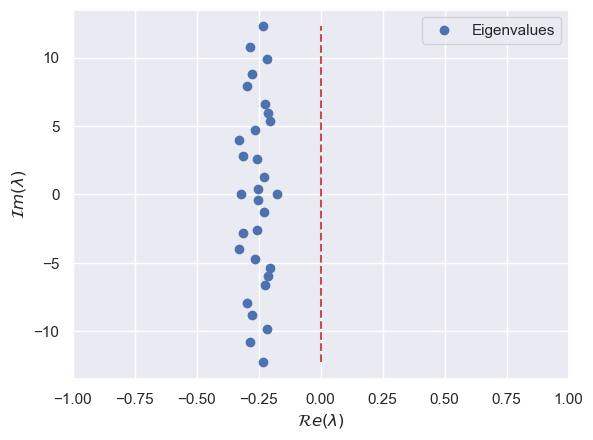

In [336]:
with torch.no_grad():
    eigv, _ = eig(lie_operator.psi.weight.cpu() - lie_operator.psi_t.weight.cpu() - torch.diag(torch.abs(lie_operator.gamma).cpu()))

plt.scatter(eigv.real, eigv.imag, label = 'Eigenvalues')
plt.vlines(0, ymin=eigv.imag.min(), ymax=eigv.imag.max(), color = 'r', linestyles='--')
plt.xlabel("$\mathcal{R}e(\lambda)$")
plt.ylabel("$\mathcal{I}m(\lambda)$")
plt.legend()
plt.grid("on")
plt.xlim(-1,1)

In [337]:
n_grid = 30
array_x1 = np.linspace(x1_min, x1_max, n_grid, dtype=np.float32)
array_x2 = np.linspace(x2_min, x2_max, n_grid, dtype=np.float32)
matrix_grid_x1, matrix_grid_x2 = np.meshgrid(array_x1, array_x2)

array3d_dynamics = np.zeros((n_grid, n_grid, 2))

for i in range(n_grid):
    for j in range(n_grid):
        array3d_dynamics[i, j, :] = duffing(np.array([matrix_grid_x1[i, j], matrix_grid_x2[i, j]]))

autoencoder.eval()
lie_operator.eval()
array3d_dynamics_pred = np.zeros((n_grid, n_grid, 2))
for i in range(n_grid):
    for j in range(n_grid):
        x1 = matrix_grid_x1[i, j]
        x2 = matrix_grid_x2[i, j]
        tensor2d_x = torch.tensor([[x1, x2]], dtype=torch.float32).to(device)
        tensor2d_observable = autoencoder.encoder(tensor2d_x)
        tensor2d_lie_observable_next = lie_operator(tensor2d_observable)
        tensor2d_predict_x_next = autoencoder.decoder(tensor2d_lie_observable_next)
        array_x_next = tensor2d_predict_x_next.cpu().detach().numpy().ravel()

        array3d_dynamics_pred[i, j, :] = array_x_next

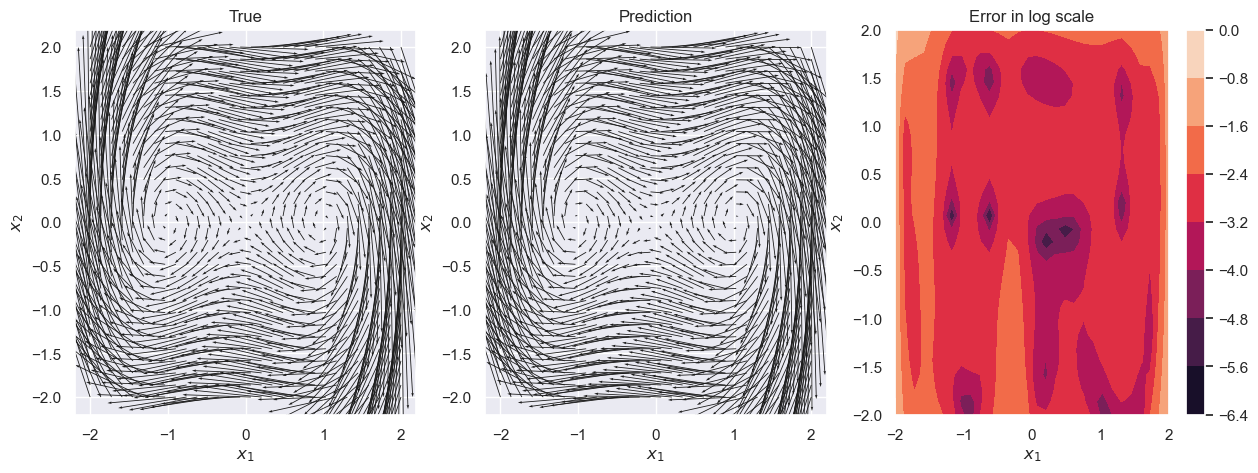

In [338]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.quiver(matrix_grid_x1, matrix_grid_x2, array3d_dynamics[:, :, 0], array3d_dynamics[:, :, 1], scale=10)
ax.set_title('True')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(132)
ax.quiver(matrix_grid_x1, matrix_grid_x2, array3d_dynamics_pred[:, :, 0], array3d_dynamics_pred[:, :, 1], scale=10)
ax.set_title('Prediction')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(133)
cp = ax.contourf(matrix_grid_x1, matrix_grid_x2,
                 np.log(np.linalg.norm(array3d_dynamics - array3d_dynamics_pred, axis=2)))
fig.colorbar(cp)
ax.set_title('Error in log scale')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()

**Question 7.** : Compare and comment below the two approaches (discrete vs continuous operator).

The continuous approach is clearly harder to make converge. Step sizes are smaller (so naturally converges slower) and number of epochs necessary for training is ten times more important.

In this practical work, we explored ideas of Koopman theory and Lie algebra, respectively in the discrete and continuous framework, to replicate the flow of a differential equation $\dot x = f(x)$. The idea to use a latent space larger than the phase space makes possible the linearization of the nonlinear differential equation possible, rendering its resolution possible with a simple neural network (activation functions are all $\sigma: x \mapsto x$), at the price of introducing two supplementary neural networks: the encoder and decoder.

**Question 8.** : Mention one of the important research paper related to this framework. Namely, _deep learning of dynamical systems with the Koopman operator_. Explain shortly the reason of your choice. 

**-- PLEASE SUBMIT YOUR COMPLETED NOTEBOOK WITH CELL OUTPUTS --**